In [1]:
import firedrake as fd
import matplotlib.pyplot as plt
import numpy as np
import ufl
import control

import hydrogym.firedrake as hgym
from lti_system import control_vec
from step_response import LinearBDFSolver

output_dir = "../eig_output"
# output_dir = "../re40_med_eig_output"
output_dir = "../re100_med_eig_output"
# output_dir = "../re40_fine_eig_output"

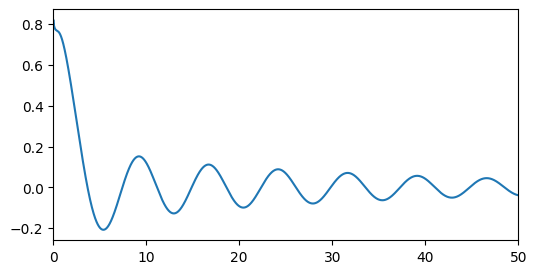

In [ ]:
# Load data from model_reduction/step_response.py
step_response = np.load("output/re40_step_response.npy")
t, CL = step_response[:, 0], step_response[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(t, CL, label="CL")
ax.set_xlim([0, 50])
plt.show()


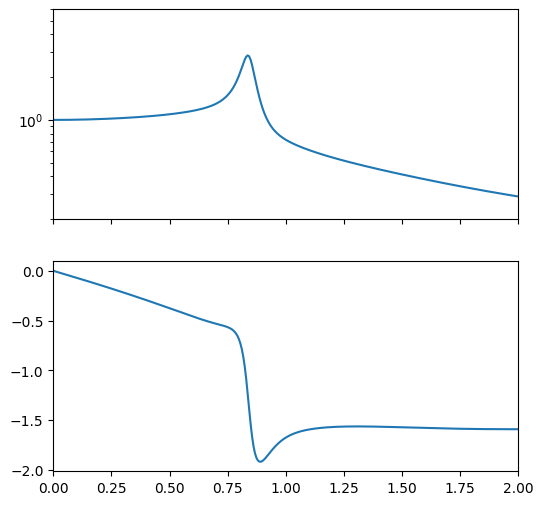

In [ ]:
# Fourier transform of the step response
# Compare to transfer_function.ipynb

fs = 1 / (t[1] - t[0])

n = len(CL)
freqs = 2 * np.pi * np.fft.fftfreq(n, d=1/fs)
CL_fft = np.sqrt(1 / 2 * np.pi) * np.fft.fft(CL) / fs

CL_fft = CL_fft / CL_fft[0]

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]))
ax[0].set_ylim(0.2, 6)
ax[1].plot(freqs[:n//2], np.angle(CL_fft[:n//2]))
ax[1].set_xlim(0, 2)
plt.show()


In [ ]:
flow = hgym.RotaryCylinder(
    Re=100,
    velocity_order=2,
    restart=f"{output_dir}/base.h5"
)

qB = flow.q.copy(deepcopy=True)

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


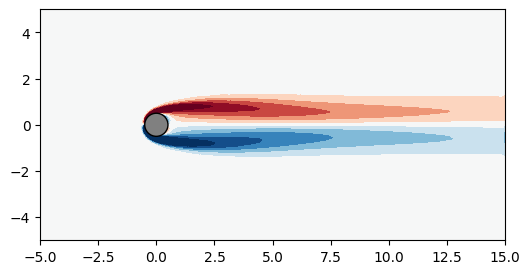

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


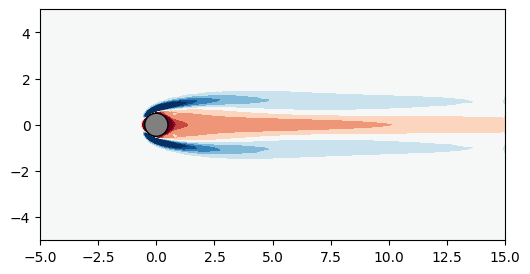

In [ ]:
# 2. Derive flow field associated with actuation BC
# See Barbagallo et al. (2009) for details on the "lifting" procedure

qC = control_vec(flow)

flow.q.assign(qC)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

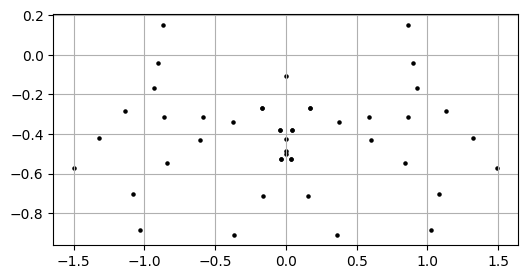

In [ ]:
# 3. Global stability
# Plot eigenvalues

evals = np.load(f"{output_dir}/evals.npy")

plt.figure(figsize=(6, 3))
plt.scatter(evals.imag, evals.real, s=5, c='k')
plt.grid()
plt.show()

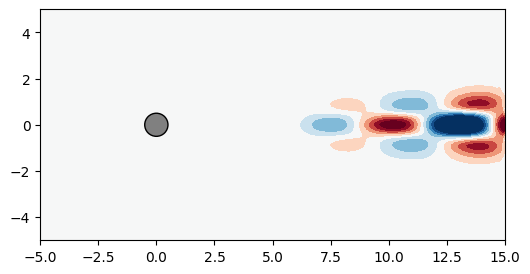

In [ ]:
idx = 0
with fd.CheckpointFile(f"{output_dir}/evecs.h5", "r") as chk:
    # mesh = chk.load_mesh("mesh")
    # q = chk.load_function(mesh, f"evec_{idx}")
    # for (u1, u2) in zip(flow.q.subfunctions, q.subfunctions):
    #     u1.project(u2)

    q = chk.load_function(flow.mesh, f"evec_{idx}")
    flow.q.assign(q)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax, clim=(-0.5, 0.5))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

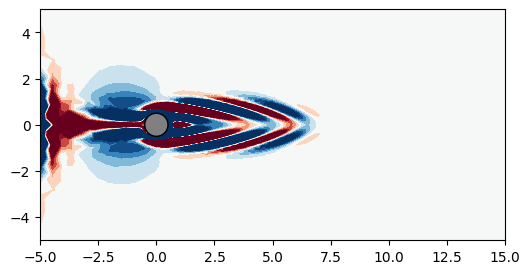

In [ ]:
idx = 0
with fd.CheckpointFile(f"{output_dir}/adj_evecs.h5", "r") as chk:
    # mesh = chk.load_mesh("mesh")
    # q = chk.load_function(mesh, f"evec_{idx}")
    # for (u1, u2) in zip(flow.q.subfunctions, q.subfunctions):
    #     u1.project(u2)

    q = chk.load_function(flow.mesh, f"evec_{idx}")
    flow.q.assign(q)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax, clim=(-50, 50))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

In [ ]:
# Load the set of eigenvectors
r = len(evals)
tol = 1e-10
V = []
with fd.CheckpointFile(f"{output_dir}/evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        V.append(q)

W = []
with fd.CheckpointFile(f"{output_dir}/adj_evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        W.append(q)


# Sort by real part
sort_idx = np.argsort(-evals.real)
evals = evals[sort_idx]

V = [V[i] for i in sort_idx]
W = [W[i] for i in sort_idx]

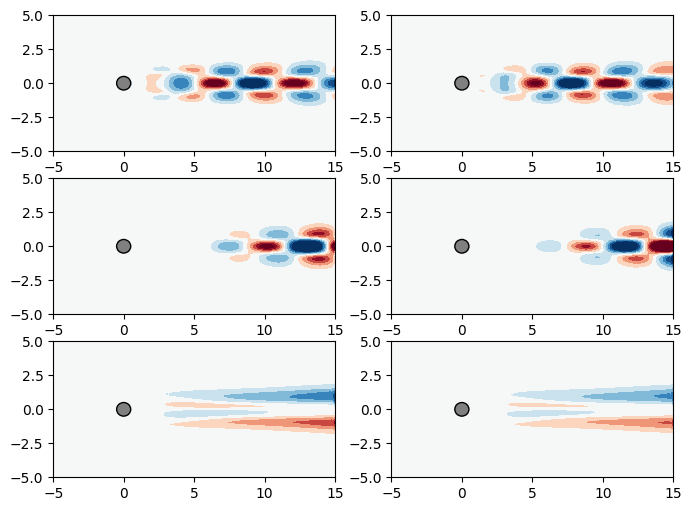

In [ ]:
# Plot direct modes

n_plt = 3
fig, ax = plt.subplots(n_plt, 2, figsize=(8, 6))

clim = (-0.5, 0.5)
for i in range(0, n_plt):

    # Real part
    flow.q.assign(V[2 * i])
    flow.render(axes=ax[i, 0], clim=clim)
    ax[i, 0].set_xlim([-5, 15])
    ax[i, 0].set_ylim([-5, 5])
    
    # Imaginary part
    flow.q.assign(-1j * V[2 * i])
    flow.render(axes=ax[i, 1], clim=clim)
    ax[i, 1].set_xlim([-5, 15])
    ax[i, 1].set_ylim([-5, 5])

plt.show()

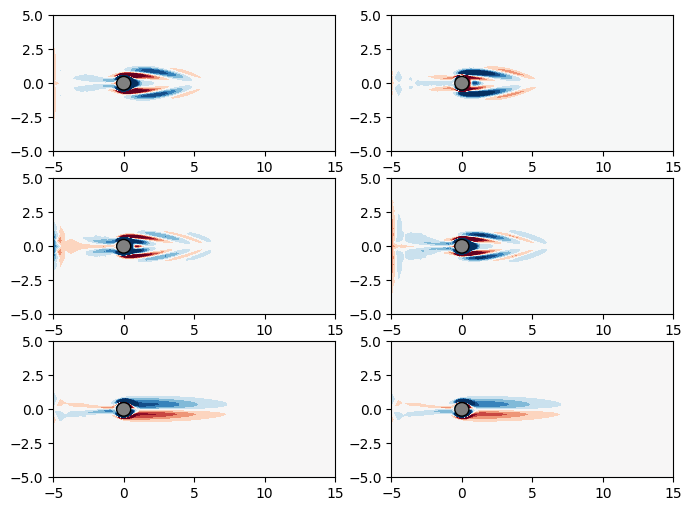

In [ ]:
# Plot adjoint modes

n_plt = 3
fig, ax = plt.subplots(n_plt, 2, figsize=(8, 6))

for i in range(0, n_plt):

    alpha = flow.inner_product(W[2 * i], W[2 * i])
    clim = np.array([-1, 1]) * np.sqrt(abs(alpha))

    # Real part
    flow.q.assign(W[2 * i])
    flow.render(axes=ax[i, 0], clim=clim)
    ax[i, 0].set_xlim([-5, 15])
    ax[i, 0].set_ylim([-5, 5])
    
    # Imaginary part
    flow.q.assign(-1j * W[2 * i])
    flow.render(axes=ax[i, 1], clim=clim)
    ax[i, 1].set_xlim([-5, 15])
    ax[i, 1].set_ylim([-5, 5])

plt.show()

In [ ]:
# 4. Projection onto global modes

r = 9  # Number of global modes for projection
# r = len(evals)
Ar = np.zeros((r, r), dtype=np.complex128)
Br = np.zeros((r, 1), dtype=np.complex128)
Cr = np.zeros((1, r), dtype=np.complex128)

A = flow.linearize(qB)
A.copy_output = True

def meas(q):
    flow.q.assign(q)
    CL, _CD = flow.get_observations()
    return CL

def real_part(q):
    return

for i in range(r):
    for j in range(r):
        # Ar[j, i] = flow.inner_product(A @ V[i], W[j])

        # Specifically for this projection, we know the result is diagonal
        Ar[j, i] = 0.0
        if i == j:
            if np.isclose(evals[i].imag, 0.0, atol=tol):
                Ar[j, i] = evals[i].real
            else:
                Ar[j, i] = evals[i]

    Br[i, 0] = flow.inner_product(qC, W[i])
    Cr[0, i] = meas(V[i])

# Finally the feedthrough term
Dr = meas(qC)

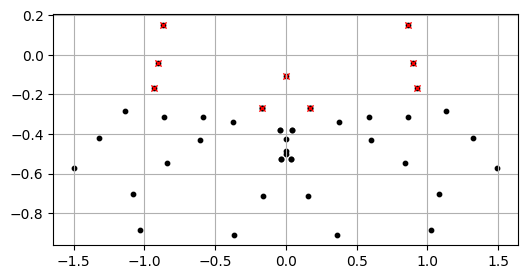

In [ ]:
rom_evals = np.linalg.eigvals(Ar)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(evals.imag, evals.real, s=10, c='k')
ax.scatter(rom_evals.imag, rom_evals.real, s=20, c='r', marker='x', linewidths=1)
ax.grid()

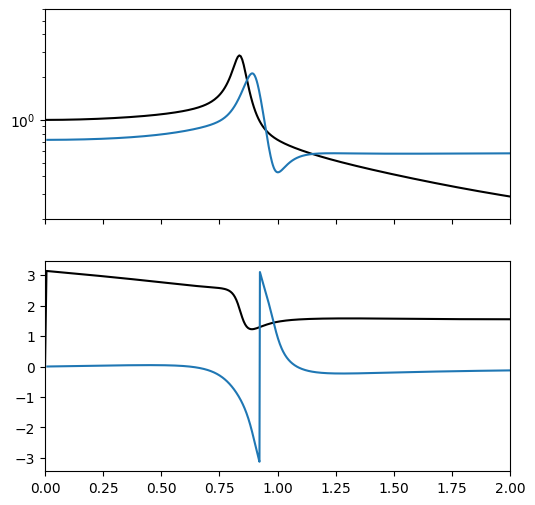

In [ ]:
def H(s):
    return Cr @ np.linalg.inv(Ar - s * np.eye(r)) @ Br + Dr

omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax[0].semilogy(omega.imag, np.abs(H_omega))
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0.2, 6)
ax[1].plot(freqs[:n//2], np.mod(np.angle(CL_fft[:n//2]), np.pi), 'k')
ax[1].plot(omega.imag, np.angle(H_omega))


In [ ]:
# Convert the system to real form
# See: https://github.com/scipy/scipy/blob/v1.12.0/scipy/linalg/_decomp.py#L1458-L1605
from scipy import linalg

def real_form(A, B, C, D):
    w = np.diag(A)
    n = w.shape[-1]

    # get indices for each first pair of complex eigenvalues
    complex_mask = np.iscomplex(w)
    n_complex = complex_mask.sum(axis=-1)

    # find complex indices
    idx = np.nonzero(complex_mask)
    idx_stack = idx[:-1]
    idx_elem = idx[-1]

    # filter them to conjugate indices, assuming pairs are not interleaved
    j = idx_elem[0::2]
    k = idx_elem[1::2]
    stack_ind = ()
    for i in idx_stack:
        # should never happen, assuming nonzero orders by the last axis
        assert (i[0::2] == i[1::2]).all(),\
                "Conjugate pair spanned different arrays!"
        stack_ind += (i[0::2],)

    # all eigenvalues to diagonal form
    Ar = np.zeros((n, n), dtype=w.real.dtype)
    di = range(n)
    Ar[di, di] = w.real

    # complex eigenvalues to real block diagonal form
    Ar[stack_ind + (j, k)] = w[stack_ind + (j,)].imag
    Ar[stack_ind + (k, j)] = w[stack_ind + (k,)].imag

    # compute real eigenvectors associated with real block diagonal eigenvalues
    u = np.zeros((n, n), dtype=np.cdouble)
    u[di, di] = 1.0
    u[stack_ind + (j, j)] = 0.5j
    u[stack_ind + (j, k)] = 0.5
    u[stack_ind + (k, j)] = -0.5j
    u[stack_ind + (k, k)] = 0.5

    # Transform the measurement matrix
    Cr = np.real(C @ u)

    # Transform the input matrix
    Br = np.real(linalg.inv(u) @ B)

    Dr = D.real

    return Ar, Br, Cr, Dr, u


Ar_real, Br_real, Cr_real, Dr_real, T = real_form(Ar, Br, Cr, Dr)

### No control

In [ ]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

tf = 100
dt = 0.01

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, constant_jacobian=True)

n_steps = int(tf // dt)
CL_nat = np.zeros(n_steps)
CD_nat = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

flow.q.assign(solver.q)
for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL_nat[i], CD_nat[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_nat[i]:.4f}, CD={CD_nat[i]:.4f}")
        print(f"   u={u[i]}")

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


t=0.00, CL=0.0098, CD=-0.0000
   u=[0.]
t=0.01, CL=0.0096, CD=-0.0000
   u=[0.]
t=0.02, CL=0.0095, CD=-0.0000
   u=[0.]
t=0.03, CL=0.0093, CD=-0.0000
   u=[0.]
t=0.04, CL=0.0091, CD=-0.0000
   u=[0.]
t=0.05, CL=0.0089, CD=-0.0000
   u=[0.]
t=0.06, CL=0.0088, CD=-0.0000
   u=[0.]
t=0.07, CL=0.0086, CD=-0.0000
   u=[0.]
t=0.08, CL=0.0084, CD=-0.0000
   u=[0.]
t=0.09, CL=0.0082, CD=-0.0000
   u=[0.]
t=0.10, CL=0.0080, CD=-0.0000
   u=[0.]
t=0.11, CL=0.0079, CD=-0.0000
   u=[0.]
t=0.12, CL=0.0077, CD=-0.0000
   u=[0.]
t=0.13, CL=0.0075, CD=-0.0000
   u=[0.]
t=0.14, CL=0.0073, CD=-0.0000
   u=[0.]
t=0.15, CL=0.0071, CD=-0.0000
   u=[0.]
t=0.16, CL=0.0069, CD=-0.0000
   u=[0.]
t=0.17, CL=0.0067, CD=-0.0000
   u=[0.]
t=0.18, CL=0.0065, CD=-0.0000
   u=[0.]
t=0.19, CL=0.0063, CD=-0.0000
   u=[0.]
t=0.20, CL=0.0062, CD=-0.0000
   u=[0.]
t=0.21, CL=0.0060, CD=-0.0000
   u=[0.]
t=0.22, CL=0.0058, CD=-0.0000
   u=[0.]
t=0.23, CL=0.0056, CD=-0.0000
   u=[0.]
t=0.24, CL=0.0054, CD=-0.0000
   u=[0.]


KeyboardInterrupt: 

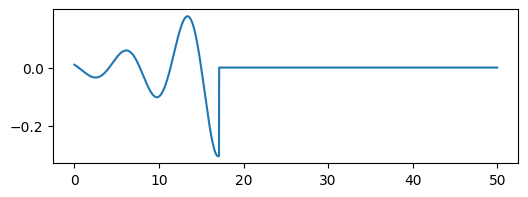

In [ ]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(1, 1, figsize=(6, 2), sharex=True)
ax.plot(t, CL_nat)
plt.show()

### Controller design

In [ ]:
complex_rom = True

if complex_rom:
    A_hat, B_hat, C_hat, D_hat = Ar, Br, Cr, Dr
else:
    A_hat, B_hat, C_hat, D_hat = Ar_real, Br_real, Cr_real, Dr_real

In [ ]:

# LQR design
Q = np.eye(r)
# Q[2:, 2:] = 0.0  # Stabilize only the first two modes
# Q[-1, -1] = 1e2  # Weight on regularizing the actuation
R = 1e-2
# K, S, E = control.lqr(A_hat, B_hat, Q, R)

P = linalg.solve_continuous_are(A_hat, B_hat, Q, R)
K = linalg.solve(R, B_hat.T) @ P

print(K)
# print(r, np.linalg.matrix_rank(control.ctrb(A_hat, B_hat)))
# print(np.linalg.matrix_rank(control.ctrb(A_hat[:2, :2], B_hat[:2])))
# print(r, np.linalg.matrix_rank(control.ctrb(Ar_real, Br_real)))

# # Kalman filter design
# noise_scale = 1e-6
# QN = noise_scale * np.eye(r+1)
# RN = noise_scale
# L, P, E = control.dlqe(dt_sys.A, np.eye(r+1), dt_sys.C, QN, RN)

[[-3.96862553e+06-8.31443212e+07j -3.96862553e+06+8.31443212e+07j
  -2.68841775e+05+1.09514366e+05j -2.68841775e+05-1.09514366e+05j
   7.78392813e-02-1.46619842e-01j  3.08406837e+05-1.38282677e+05j
   3.08406837e+05+1.38282677e+05j  9.02880591e-01-3.08153639e-01j
   9.02880542e-01+3.08153701e-01j]]


(0.0, 2.0)

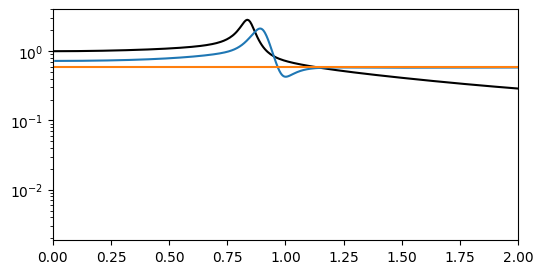

In [ ]:
def H_cl(s):
    return C_hat @ np.linalg.inv((A_hat - B_hat @ K) - s * np.eye(r)) @ B_hat + D_hat

# Plot the transfer function
omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])
H_cl_omega = np.array([H_cl(s).ravel() for s in omega])

fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
ax.semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax.semilogy(omega.imag, np.abs(H_omega))
ax.semilogy(omega.imag, np.abs(H_cl_omega))
ax.set_xlim(0, 2)

### Small-gain limit

See 6.2 in Barbagallo et al.

In [ ]:
ru = 2

Q = np.zeros((ru, ru))
R = np.eye(m)
P = linalg.solve_continuous_are(A_hat[:ru, :ru], B_hat[:ru], Q, R)

K = np.zeros_like(B_hat.T)
Ku = linalg.solve(R, B_hat[:ru].T) @ P
K[:, :ru] = Ku
Ku

# Integral control on the actuation to drive the BC value to zero
ki = 1e-1

# Q = 1e-8 * np.eye(ru)
# control.lqr(Ar[:ru, :ru], Br[:ru], Q, R)

(0.0, 2.0)

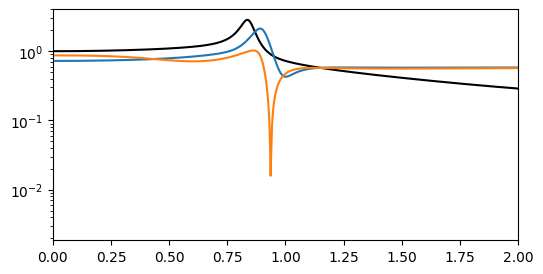

In [ ]:
def H_cl(s):
    return C_hat @ np.linalg.inv((A_hat - B_hat @ K) - s * np.eye(r)) @ B_hat + D_hat

# Plot the transfer function
omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])
H_cl_omega = np.array([H_cl(s).ravel() for s in omega])

fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
ax.semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax.semilogy(omega.imag, np.abs(H_omega))
ax.semilogy(omega.imag, np.abs(H_cl_omega))
ax.set_xlim(0, 2)

### LQR control only

Full state measurement in the reduced basis by projecting the field at every time step. Intended for debugging only

In [ ]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

c = fd.Constant(0.0)
f = c * qC.subfunctions[0].copy(deepcopy=True)

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

# solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=qC)
solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, f=f)

# tf = 100
# n_steps = int(tf // dt)
CL_ctrl = np.zeros(n_steps)
CD_ctrl = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

# # Integrated control signal (this is the BC value)
# c = np.zeros((n_steps, m))

rho = np.zeros(n_steps)
# rho = 0.0

flow.q.assign(solver.q)
for i in range(n_steps):
    # Project the flow field onto the reduced basis
    z = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])

    if i > 0:
        # Transform to the real-valued reduced state space
        x[i] = np.real(T @ z)

        # LQR control
        if complex_rom:
            u[i] = np.real(K @ z)
        else:
            u[i] = K @ x[i]

        # Small proportional control applied to the actuation to
        # drive the BC value to zero
        u[i] += 1e-1 * rho[i-1]

        c.assign(u[i])

        rho[i] = rho[i-1] - dt * u[i]

    q = solver.step()
    flow.q.assign(q)
    CL_ctrl[i], CD_ctrl[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_ctrl[i]:.4f}, CD={CD_ctrl[i]:.4f}")
        print(f"   u={u[i]}, rho={rho[i]}")

t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], rho=0.0
t=0.01, CL=0.0087, CD=0.0000
   u=[-0.08348229], rho=0.0008348229042186159
t=0.02, CL=0.0072, CD=0.0000
   u=[-0.08182995], rho=0.0016531223878707558
t=0.03, CL=0.0057, CD=0.0000
   u=[-0.07997622], rho=0.0024528845937631595
t=0.04, CL=0.0042, CD=0.0000
   u=[-0.07805264], rho=0.003233411042884149
t=0.05, CL=0.0028, CD=0.0000
   u=[-0.07610329], rho=0.00399444390894441
t=0.06, CL=0.0013, CD=0.0000
   u=[-0.07414301], rho=0.004735874005906559
t=0.07, CL=-0.0000, CD=0.0000
   u=[-0.07217693], rho=0.005457643306018657
t=0.08, CL=-0.0014, CD=0.0000
   u=[-0.07020691], rho=0.006159712397753057
t=0.09, CL=-0.0027, CD=0.0000
   u=[-0.06823372], rho=0.006842049622032251
t=0.10, CL=-0.0040, CD=0.0000
   u=[-0.06625778], rho=0.007504627444861851
t=0.11, CL=-0.0052, CD=0.0000
   u=[-0.06427938], rho=0.008147421245379444
t=0.12, CL=-0.0064, CD=0.0000
   u=[-0.06229877], rho=0.00877040891000596
t=0.13, CL=-0.0076, CD=0.0000
   u=[-0.06031618], rho=0.

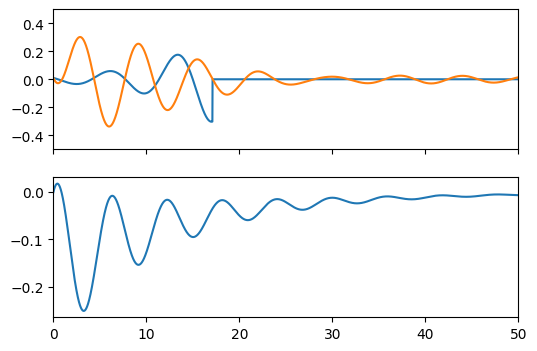

In [ ]:
t = np.arange(n_steps) * dt

# y = x @ dt_sys.C.T  # Predicted CL
# print(y.shape)

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(dt * np.arange(len(CL_nat)), CL_nat)
ax[0].plot(dt * np.arange(len(CL_ctrl)), CL_ctrl)
ax[0].set_ylim([-0.5, 0.5])
# ax[0].plot(t, y)
# ax[1].plot(t, x)
# ax[1].plot(t, u)
ax[1].plot(dt * np.arange(len(rho)), rho)
ax[1].set_xlim([0, 50])
plt.show()


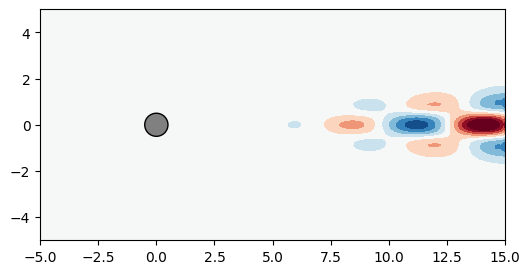

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

### Boundary condition control

In [ ]:
 # The full flow field with BCs is q = qH + qC * rho, where qH is the solution
# to the homogeneous problem with forcing.  Since the controller was designed
# based on qH, this is the value we want to use for the feedback: u = K * x, with
# x = T @ z the real-valued reduced state and z = W^T @ qH = W^T @ (q - qC * rho)
# the complex-valued reduced state (in the eigenbasis).  We can pre-compute the term
# T @ (W^T @ qC) and subtract it from the full flow field projection at each step

zC = np.array([flow.inner_product(qC, W[j]) for j in range(r)])
xC = np.real(T @ zC)

# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

# Can't have a constant Jacobian here because we need to update the control,
# which changes the assembled matrix via the Dirichlet BC
solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0)

# tf = 100
# n_steps = int(tf // dt)
CL_bc = np.zeros(n_steps)
CD_bc = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

# Integrated control signal (this is the BC value)
rho = np.zeros((n_steps, m))

flow.q.assign(solver.q)
for i in range(n_steps):

    # LQR control
    if i > 0: 
        # Project the flow field onto the reduced basis
        z = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])

        # Transform to the real-valued reduced state space and offset by
        # the BC value to shift to the corresponding homogeneous solution
        x[i] = np.real(T @ z)

        # LQR control
        if complex_rom:
            u[i] = np.real(K @ (z - zC * rho[i-1]))
        else:
            u[i] = K @ (x[i] - xC * rho[i-1])

        # Small proportional control applied to the actuation to
        # drive the BC value to zero
        u[i] += 1e-1 * rho[i-1]

        # The Dirichlet boundary condition is the integrated negative control signal
        # c(t) = -drho/dt
        if i > 0:
            rho[i] = rho[i-1] - dt * u[i]

        # bc_scale = flow.advance_time(dt, c[i])[0].real
        # rho[i] = np.clip(bc_scale, -flow.MAX_CONTROL, flow.MAX_CONTROL)
        # flow.set_control(c[i])
        flow.bcu_actuation[0].set_scale(rho[i])

    q = solver.step()
    flow.q.assign(q)
    CL_bc[i], CD_bc[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_bc[i]:.4f}, CD={CD_bc[i]:.4f}")
        print(f"   u={u[i]}, rho={rho[i]}")

t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], rho=[0.]
t=0.01, CL=0.0087, CD=0.0000
   u=[-0.08348229], rho=[0.00083482]
t=0.02, CL=0.0076, CD=0.0000
   u=[-0.0816973], rho=[0.0016518]
t=0.03, CL=0.0065, CD=0.0000
   u=[-0.07980138], rho=[0.00244981]
t=0.04, CL=0.0055, CD=0.0000
   u=[-0.07786601], rho=[0.00322847]
t=0.05, CL=0.0045, CD=-0.0000
   u=[-0.07591508], rho=[0.00398762]
t=0.06, CL=0.0035, CD=-0.0000
   u=[-0.07395671], rho=[0.00472719]
t=0.07, CL=0.0026, CD=-0.0000
   u=[-0.07199375], rho=[0.00544713]
t=0.08, CL=0.0017, CD=-0.0000
   u=[-0.07002728], rho=[0.0061474]
t=0.09, CL=0.0008, CD=-0.0000
   u=[-0.06805784], rho=[0.00682798]
t=0.10, CL=-0.0000, CD=-0.0000
   u=[-0.06608574], rho=[0.00748883]
t=0.11, CL=-0.0009, CD=-0.0000
   u=[-0.06411126], rho=[0.00812995]
t=0.12, CL=-0.0017, CD=-0.0000
   u=[-0.06213462], rho=[0.00875129]
t=0.13, CL=-0.0025, CD=-0.0000
   u=[-0.06015606], rho=[0.00935285]
t=0.14, CL=-0.0032, CD=-0.0000
   u=[-0.05817582], rho=[0.00993461]
t=0.15, CL=-0.

KeyboardInterrupt: 

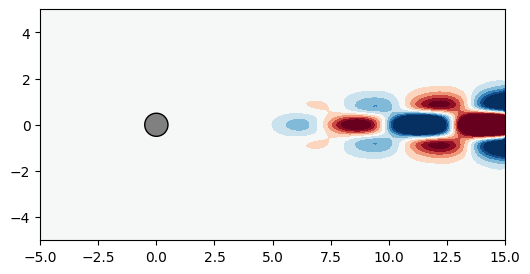

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

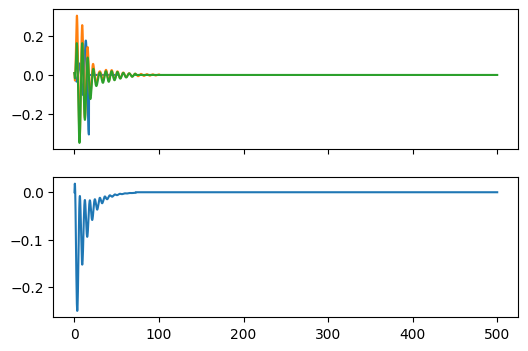

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(dt * np.arange(len(CL_nat)), CL_nat)
ax[0].plot(dt * np.arange(len(CL_ctrl)), CL_ctrl)
ax[0].plot(dt * np.arange(len(CL_bc)), CL_bc)
# ax[0].set_ylim([-2, 2])

# ax[1].plot(t, CD_ctrl)
# ax[1].plot(t, CD_bc)

# ax[1].plot(dt * np.arange(len(rho)), x - xC * rho)
# ax[1].plot(dt * np.arange(len(rho)), x)
ax[1].plot(dt * np.arange(len(rho)), rho)

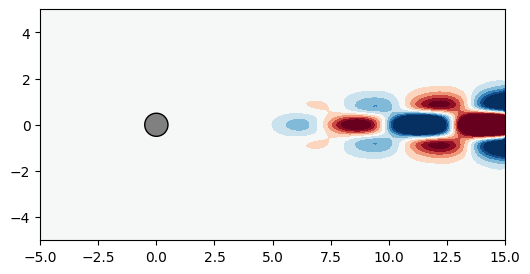

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
plt.show()

In [ ]:
# # Observation vector
# (u, p) = fd.split(q)
# # Lift/drag on cylinder
# force = -dot(self.sigma(u, p), self.n)
# CL = fd.assemble(2 * force[1] * ds(self.CYLINDER))

# Full LQG control

In [ ]:
# # Second-order BDF time-stepping
# lin_flow = flow.linearize(qB)
# fn_space = lin_flow.function_space
# bcs = lin_flow.bcs

# J = lin_flow.J

# # Can't have a constant Jacobian here because we need to update the control,
# # which changes the assembled matrix via the Dirichlet BC
# solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=qC, constant_jacobian=False)

# tf = 10
# n_steps = int(tf // dt)
# CL = np.zeros(n_steps)
# CD = np.zeros(n_steps)

# m = 1

# x = np.zeros((n_steps, r))  # Kalman filter state
# u = np.zeros((n_steps, m))  # Control signal

# # Integrated control signal (this is the BC value)
# c = np.zeros((n_steps, m))

# for i in range(n_steps):
#     # LQR control
#     if i > 0:
#         u[i] = -K @ x[i]

#         # The Dirichlet boundary condition is the integrated control signal
#         if i > 0:
#             c[i] = c[i-1] + dt * u[i]

#         bc_scale = flow.advance_time(dt, c[i])[0].real
#         c[i] = np.clip(bc_scale, -flow.MAX_CONTROL, flow.MAX_CONTROL)
#         flow.set_control(c[i])

#     q = solver.step()
#     flow.q.assign(q)
#     CL[i], CD[i] = map(np.real, flow.get_observations())

#     # Update Kalman filter state
#     y = CL[i]
#     # x = dt_sys.A @ x + dt_sys.B @ K @ x + L @ (y - dt_sys.C @ x)
#     y_hat = dt_sys.C @ x[i]
#     if i < n_steps - 1:
#         x[i+1] = dt_sys.A @ x[i] + dt_sys.B @ u[i] + L @ (y - y_hat)

#     if i % 10 == 0:
#         print(f"t={i*dt:.2f}, CL={CL[i]:.4f}, CD={CD[i]:.4f}")
#         print(f"   y_hat={y_hat}, u={u[i]}")

t=0.00, CL=1.7369, CD=-0.0014
   y_hat=[0.], u=[0.]
t=0.10, CL=1.7486, CD=-0.0000
   y_hat=[0.29251455], u=[-11.87083937]
t=0.20, CL=1.9888, CD=-0.0000
   y_hat=[0.5103877], u=[-19.05402217]
t=0.30, CL=2.3498, CD=0.0000
   y_hat=[0.65053309], u=[-24.64590592]
t=0.40, CL=2.8073, CD=0.0001
   y_hat=[0.7133787], u=[-30.39778042]
t=0.50, CL=3.1495, CD=0.0003
   y_hat=[0.69622098], u=[-37.25813948]
t=0.60, CL=3.1073, CD=0.0003
   y_hat=[0.51529121], u=[-42.68234219]
t=0.70, CL=3.0808, CD=0.0003
   y_hat=[0.14972312], u=[-47.46219174]
t=0.80, CL=3.0497, CD=0.0003
   y_hat=[-0.38715522], u=[-53.07806996]
t=0.90, CL=3.0049, CD=0.0003
   y_hat=[-1.08704663], u=[-60.3612617]
t=1.00, CL=2.9417, CD=0.0003
   y_hat=[-1.94988638], u=[-69.77657218]
t=1.10, CL=2.8588, CD=0.0003
   y_hat=[-2.98463969], u=[-81.61738499]
t=1.20, CL=2.7564, CD=0.0003
   y_hat=[-4.20892085], u=[-96.1361643]
t=1.30, CL=2.6359, CD=0.0003
   y_hat=[-5.64833324], u=[-113.62559901]
t=1.40, CL=2.4992, CD=0.0003
   y_hat=[-7.3360

KeyboardInterrupt: 

In [ ]:
flow.MAX_CONTROL

1.5707963267948966

(199, 1)


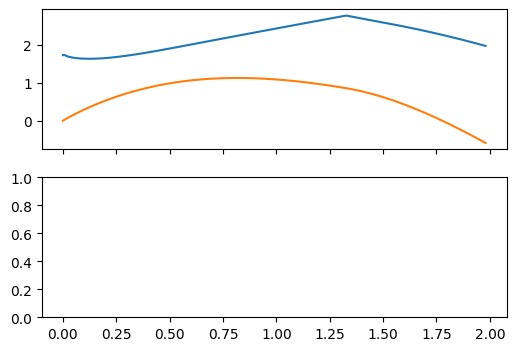

In [ ]:
# t = np.arange(n_steps) * dt

# y = x @ dt_sys.C.T  # Predicted CL
# print(y.shape)

# fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
# ax[0].plot(t, CL)
# ax[0].plot(t, y)
# # ax[1].plot(t, u)
# plt.show()
